In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score
import numpy as np
import re
import jieba

df = pd.read_csv('ChnSentiCorp_htl_all_translated.csv')
df['review'] = df['review'].apply(str)
df['translated_review'] = df['translated_review'].apply(str)

# Define a function to keep only Chinese characters in a string
def keep_chinese(text):
    pattern = re.compile(r'[^\u4e00-\u9fff\s]')
    chinese_only = pattern.sub('', text)
    return chinese_only.strip()

# Tokenize the Chinese words and keep only the Chinese characters in each word
df['words-chinese'] = df['review'].apply(lambda x: [keep_chinese(word) for word in jieba.cut(x, cut_all=False) if keep_chinese(word) != ''])

# Calculate the mean of TF-IDF values for each tokenized sentence
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['words-chinese'].apply(lambda x: ' '.join(x)))
df['tf-idf'] = np.mean(X_tfidf.toarray(), axis=1)

# Train a Word2Vec model and calculate the mean of word embeddings for each tokenized sentence
word2vec_model = Word2Vec(sentences=df['words-chinese'], vector_size=100, window=5, min_count=1, workers=4)

def mean_word2vec(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['word2vec'] = df['words-chinese'].apply(lambda x: mean_word2vec(x, word2vec_model))

# Combine the reshaped 'tf-idf' values and 'word2vec' values
X = np.hstack((X_tfidf.toarray(), np.vstack(df['word2vec'].values)))
y = df['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = svm_model.predict(X_test)

# Calculate and report the F1 score, recall, and accuracy
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print('F1 Score:', f1)
print('Recall:', recall)
print('Accuracy:', accuracy)

/Users/hangao/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/_9/2z47shtd34x8z5gsxhf75_jr0000gn/T/jieba.cache
Loading model cost 0.488 seconds.
Prefix dict has been built successfully.


In [15]:
from sklearn.model_selection import KFold

# Initialize the KFold cross-validator with k=5
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
f1_scores = []
recall_scores = []
accuracy_scores = []

# Iterate over the k folds
for train_index, test_index in kfold.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the SVM classifier
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = svm_model.predict(X_test)

    # Calculate and store the performance metrics for the current fold
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Calculate and report the average F1 score, recall, and accuracy across all k folds
average_f1 = np.mean(f1_scores)
average_recall = np.mean(recall_scores)
average_accuracy = np.mean(accuracy_scores)

print(f'Average F1 Score (k={k}):', average_f1)
print(f'Average Recall (k={k}):', average_recall)
print(f'Average Accuracy (k={k}):', average_accuracy)

Average F1 Score (k=5): 0.8235100527269335
Average Recall (k=5): 0.8261671477383004
Average Accuracy (k=5): 0.8261671477383004


In [18]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score
import numpy as np
import re
import nltk

df = pd.read_csv('ChnSentiCorp_htl_all_translated.csv')
df['review'] = df['review'].apply(str)
df['translated_review'] = df['translated_review'].apply(str)

# Define a function to keep only English characters in a string
def keep_english(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    english_only = pattern.sub('', text)
    return english_only.strip()

# Tokenize the English words and keep only the English characters in each word
df['words-english'] = df['translated_review'].apply(lambda x: [keep_english(word) for word in nltk.word_tokenize(x) if keep_english(word) != ''])

# Calculate the mean of TF-IDF values for each tokenized sentence
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['words-english'].apply(lambda x: ' '.join(x)))
df['tf-idf'] = np.mean(X_tfidf.toarray(), axis=1)

In [19]:
# Train a Word2Vec model and calculate the mean of word embeddings for each tokenized sentence
word2vec_model = Word2Vec(sentences=df['words-english'], vector_size=100, window=5, min_count=1, workers=4)

def mean_word2vec(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['word2vec'] = df['words-english'].apply(lambda x: mean_word2vec(x, word2vec_model))

# Combine the reshaped 'tf-idf' values and 'word2vec' values
X = np.hstack((df['tf-idf'].values.reshape(-1, 1), np.vstack(df['word2vec'].values)))
y = df['label'].values

# Initialize the KFold cross-validator with k=5
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store performance metrics for each fold
f1_scores = []
recall_scores = []
accuracy_scores = []

# Iterate over the k folds
for train_index, test_index in kfold.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the SVM classifier
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = svm_model.predict(X_test)

    # Calculate and store the performance metrics for the current fold
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# Calculate and report the average F1 score, recall, and accuracy across all k folds
average_f1 = np.mean(f1_scores)
average_recall = np.mean(recall_scores)
average_accuracy = np.mean(accuracy_scores)

print(f'Average F1 Score (k={k}):', average_f1)
print(f'Average Recall (k={k}):', average_recall)
print(f'Average Accuracy (k={k}):', average_accuracy)

Average F1 Score (k=5): 0.7825070377602008
Average Recall (k=5): 0.7880528490959915
Average Accuracy (k=5): 0.7880528490959915


In [1]:
# Language: Chinese
# Compare 80/20, 70/30, 60/40 and 50/50 ratios
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score
import numpy as np
import re
import jieba

df = pd.read_csv('ChnSentiCorp_htl_all_translated.csv')
df['review'] = df['review'].apply(str)
df['translated_review'] = df['translated_review'].apply(str)

# Define a function to keep only Chinese characters in a string
def keep_chinese(text):
    pattern = re.compile(r'[^\u4e00-\u9fff\s]')
    chinese_only = pattern.sub('', text)
    return chinese_only.strip()

# Tokenize the Chinese words and keep only the Chinese characters in each word
df['words-chinese'] = df['review'].apply(lambda x: [keep_chinese(word) for word in jieba.cut(x, cut_all=False) if keep_chinese(word) != ''])

# Calculate the mean of TF-IDF values for each tokenized sentence
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['words-chinese'].apply(lambda x: ' '.join(x)))
df['tf-idf'] = np.mean(X_tfidf.toarray(), axis=1)

# Train a Word2Vec model and calculate the mean of word embeddings for each tokenized sentence
word2vec_model = Word2Vec(sentences=df['words-chinese'], vector_size=100, window=5, min_count=1, workers=4)

def mean_word2vec(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['word2vec'] = df['words-chinese'].apply(lambda x: mean_word2vec(x, word2vec_model))

# Combine the reshaped 'tf-idf' values and 'word2vec' values
X = np.hstack((tf_idf_reshaped, np.vstack(df['word2vec'].values)))
y = df['label'].values

# Test different train/test ratios
ratios = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
results = []
for ratio in ratios:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-ratio), random_state=42)

    # Train the SVM classifier
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = svm_model.predict(X_test)

    # Calculate and report the F1 score, recall, and accuracy
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append((ratio, f1, recall, accuracy))

# Print the results
print('Train/Test Ratio\tF1 Score\tRecall\tAccuracy')
for result in results:
    print('{}\t{:.4f}\t\t{:.4f}\t{:.4f}'.format(result[0], result[1], result[2], result[3]))

/Users/hangao/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/_9/2z47shtd34x8z5gsxhf75_jr0000gn/T/jieba.cache
Loading model cost 0.460 seconds.
Prefix dict has been built successfully.


NameError: name 'tf_idf_reshaped' is not defined

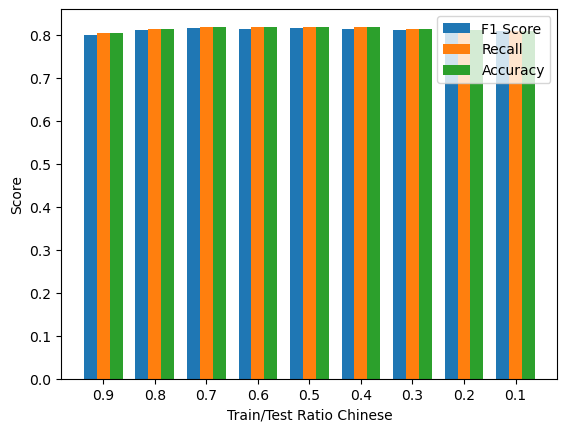

In [30]:
# Language: Chinese
# Compare 80/20, 70/30, 60/40 and 50/50 ratios

import matplotlib.pyplot as plt
import numpy as np

# Get the data for the graph
labels = [result[0] for result in results]
f1_scores = [result[1] for result in results]
recall_scores = [result[2] for result in results]
accuracy_scores = [result[3] for result in results]

# Set the width of the bars and the x-axis offset
bar_width = 0.25
x_offset = np.arange(len(labels))

# Plot the data as a grouped bar graph
fig, ax = plt.subplots()
ax.bar(x_offset - bar_width, f1_scores, width=bar_width, label='F1 Score')
ax.bar(x_offset, recall_scores, width=bar_width, label='Recall')
ax.bar(x_offset + bar_width, accuracy_scores, width=bar_width, label='Accuracy')

# Add labels and legend
ax.set_xlabel('Train/Test Ratio Chinese')
ax.set_ylabel('Score')
ax.set_xticks(x_offset)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()

In [38]:
# Chinese k-fold k = [5, 6, 9, 10, 15, 20]
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
import numpy as np
import re
import jieba
import matplotlib.pyplot as plt

df = pd.read_csv('ChnSentiCorp_htl_all_translated.csv')
df['review'] = df['review'].apply(str)
df['translated_review'] = df['translated_review'].apply(str)

# Define a function to keep only Chinese characters in a string
def keep_chinese(text):
    pattern = re.compile(r'[^\u4e00-\u9fff\s]')
    chinese_only = pattern.sub('', text)
    return chinese_only.strip()

# Tokenize the Chinese words and keep only the Chinese characters in each word
df['words-chinese'] = df['review'].apply(lambda x: [keep_chinese(word) for word in jieba.cut(x, cut_all=False) if keep_chinese(word) != ''])

# Calculate the mean of TF-IDF values for each tokenized sentence
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['words-chinese'].apply(lambda x: ' '.join(x)))
df['tf-idf'] = np.mean(X_tfidf.toarray(), axis=1)

# Train a Word2Vec model and calculate the mean of word embeddings for each tokenized sentence
word2vec_model = Word2Vec(sentences=df['words-chinese'], vector_size=100, window=5, min_count=1, workers=4)

def mean_word2vec(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['word2vec'] = df['words-chinese'].apply(lambda x: mean_word2vec(x, word2vec_model))

# Combine the reshaped 'tf-idf' values and 'word2vec' values
X = np.hstack((tf_idf_reshaped, np.vstack(df['word2vec'].values)))
y = df['label'].values

# Test different k-values
k_values = [5, 6, 9, 10, 15, 20]
results = []
for k in k_values:
    # Initialize the KFold cross-validator with the current k-value
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    # Initialize lists to store performance metrics for each fold
    f1_scores = []
    recall_scores = []
    accuracy_scores = []
    precision_scores = []

    # Iterate over the k folds
    for train_index, test_index in kfold.split(X):
        # Split the data into training and testing sets for the current fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the SVM classifier
        svm_model = SVC(kernel='linear', random_state=42)
        svm_model.fit(X_train, y_train)

        # Predict on the testing set
        y_pred = svm_model.predict(X_test)

        # Calculate and store the performance metrics for the current fold
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))

    # Calculate and store the average performance metrics across all k folds for the current k-value
    average_f1 = np.mean(f1_scores)
    average_recall = np.mean(recall_scores)
    average_accuracy = np.mean(accuracy_scores)
    average_precision = np.mean(precision_scores)

    results.append((k, average_f1, average_recall, average_accuracy, average_precision))

    # Print the results for the current k-value
    print(f'k={k}, F1 Score: {average_f1:.4f}, Recall: {average_recall:.4f}, Accuracy: {average_accuracy:.4f}, Precision: {average_precision:.4f}')

k=5, F1 Score: 0.8220, Recall: 0.8246, Accuracy: 0.8246, Precision: 0.8213
k=6, F1 Score: 0.8219, Recall: 0.8246, Accuracy: 0.8246, Precision: 0.8212
k=9, F1 Score: 0.8223, Recall: 0.8250, Accuracy: 0.8250, Precision: 0.8217
k=10, F1 Score: 0.8234, Recall: 0.8259, Accuracy: 0.8259, Precision: 0.8228
k=15, F1 Score: 0.8232, Recall: 0.8258, Accuracy: 0.8258, Precision: 0.8229
k=20, F1 Score: 0.8243, Recall: 0.8268, Accuracy: 0.8268, Precision: 0.8241


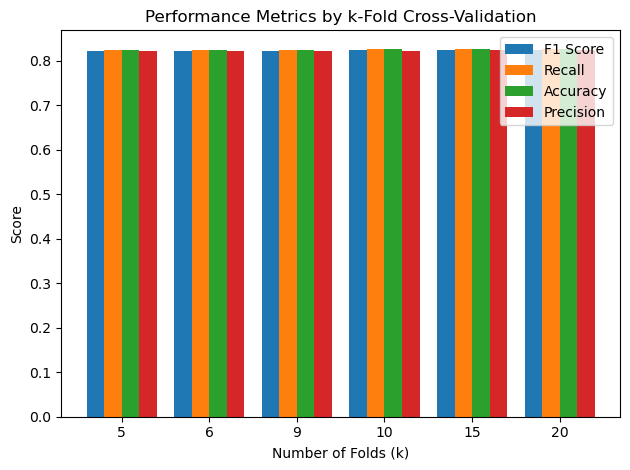

In [39]:
# Chinese k-fold k = [5, 6, 9, 10, 15, 20]
# Plot the results as a grouped bar graph
metrics = ['F1 Score', 'Recall', 'Accuracy', 'Precision']
k_values_str = [str(k) for k in k_values]
x = np.arange(len(k_values_str))
width = 0.2
fig, ax = plt.subplots()
for i in range(len(metrics)):
    values = [result[i+1] for result in results]
    rects = ax.bar(x + (i - 1.5) * width, values, width, label=metrics[i])
ax.set_ylabel('Score')
ax.set_xlabel('Number of Folds (k)')
ax.set_title('Performance Metrics by k-Fold Cross-Validation')
ax.set_xticks(x)
ax.set_xticklabels(k_values_str)
ax.legend()
fig.tight_layout()
plt.show()

In [41]:
# Language: English
# k-fold comparison

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
import numpy as np
import re
import nltk

df = pd.read_csv('ChnSentiCorp_htl_all_translated.csv')
df['review'] = df['review'].apply(str)
df['translated_review'] = df['translated_review'].apply(str)

# Define a function to keep only English characters in a string
def keep_english(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    english_only = pattern.sub('', text)
    return english_only.strip()

# Tokenize the English words and keep only the English characters in each word
df['words-english'] = df['translated_review'].apply(lambda x: [keep_english(word) for word in nltk.word_tokenize(x) if keep_english(word) != ''])

# Calculate the mean of TF-IDF values for each tokenized sentence
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['words-english'].apply(lambda x: ' '.join(x)))
df['tf-idf'] = np.mean(X_tfidf.toarray(), axis=1)

# Train a Word2Vec model and calculate the mean of word embeddings for each tokenized sentence
word2vec_model = Word2Vec(sentences=df['words-english'], vector_size=100, window=5, min_count=1, workers=4)

def mean_word2vec(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['word2vec'] = df['words-english'].apply(lambda x: mean_word2vec(x, word2vec_model))

# Combine the reshaped 'tf-idf' values and 'word2vec' values
X = np.hstack((df['tf-idf'].values.reshape(-1, 1), np.vstack(df['word2vec'].values)))
y = df['label'].values

# Define the values of k to iterate over
k_values = [5, 6, 9, 10, 15, 20]

# Initialize an empty list to store the results for each value of k
results = []

# Iterate over the k values and perform k-fold cross-validation
for k in k_values:
    # Initialize the KFold cross-validator with the current value of k
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    # Initialize lists to store performance metrics for each fold
    f1_scores = []
    recall_scores = []
    accuracy_scores = []
    precision_scores = []

    # Iterate over the k folds
    for train_index, test_index in kfold.split(X):
        # Split the data into training and testing sets for the current fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the SVM classifier
        svm_model = SVC(kernel='linear', random_state=42)
        svm_model.fit(X_train, y_train)

        # Predict on the testing set
        y_pred = svm_model.predict(X_test)

        # Calculate and store the performance metrics for the current fold
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))

    # Calculate and store the average performance metrics for the current value of k
    average_f1 = np.mean(f1_scores)
    average_recall = np.mean(recall_scores)
    average_accuracy = np.mean(accuracy_scores)
    average_precision = np.mean(precision_scores)
    results.append([k, average_f1, average_recall, average_accuracy, average_precision])
    # Print the results for the current k-value
    print(f'k={k}, F1 Score: {average_f1:.4f}, Recall: {average_recall:.4f}, Accuracy: {average_accuracy:.4f}, Precision: {average_precision:.4f}')

k=5, F1 Score: 0.7855, Recall: 0.7906, Accuracy: 0.7906, Precision: 0.7847
k=6, F1 Score: 0.7851, Recall: 0.7902, Accuracy: 0.7902, Precision: 0.7843
k=9, F1 Score: 0.7852, Recall: 0.7902, Accuracy: 0.7902, Precision: 0.7844
k=10, F1 Score: 0.7869, Recall: 0.7920, Accuracy: 0.7920, Precision: 0.7863
k=15, F1 Score: 0.7843, Recall: 0.7893, Accuracy: 0.7893, Precision: 0.7841
k=20, F1 Score: 0.7846, Recall: 0.7895, Accuracy: 0.7895, Precision: 0.7845


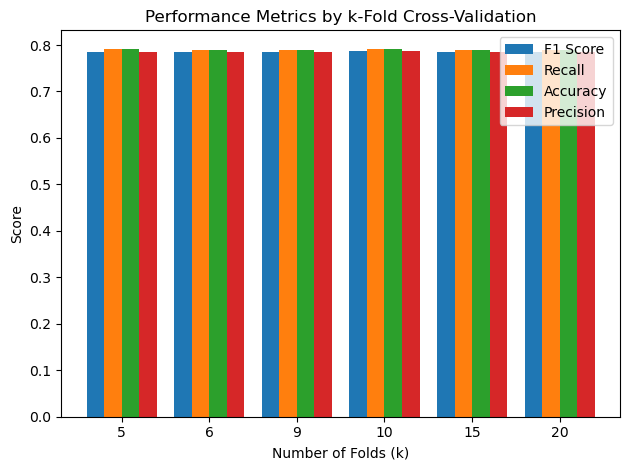

In [42]:
# Language: English
# k-fold comparison

# Plot the results as a grouped bar graph
metrics = ['F1 Score', 'Recall', 'Accuracy', 'Precision']
k_values_str = [str(k) for k in k_values]
x = np.arange(len(k_values_str))
width = 0.2
fig, ax = plt.subplots()
for i in range(len(metrics)):
    values = [result[i+1] for result in results]
    rects = ax.bar(x + (i - 1.5) * width, values, width, label=metrics[i])
ax.set_ylabel('Score')
ax.set_xlabel('Number of Folds (k)')
ax.set_title('Performance Metrics by k-Fold Cross-Validation')
ax.set_xticks(x)
ax.set_xticklabels(k_values_str)
ax.legend()
fig.tight_layout()
plt.show()

In [47]:
# English train/test ratio
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('ChnSentiCorp_htl_all_translated.csv')
df['review'] = df['review'].apply(str)
df['translated_review'] = df['translated_review'].apply(str)

# Define a function to keep only English characters in a string
def keep_english(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    english_only = pattern.sub('', text)
    return english_only.strip()

# Tokenize the English words and keep only the English characters in each word
df['words-english'] = df['translated_review'].apply(lambda x: [keep_english(word) for word in nltk.word_tokenize(x) if keep_english(word) != ''])

# Calculate the mean of TF-IDF values for each tokenized sentence
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['words-english'].apply(lambda x: ' '.join(x)))
df['tf-idf'] = np.mean(X_tfidf.toarray(), axis=1)

# Train a Word2Vec model and calculate the mean of word embeddings for each tokenized sentence
word2vec_model = Word2Vec(sentences=df['words-english'], vector_size=100, window=5, min_count=1, workers=4)

def mean_word2vec(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['word2vec'] = df['words-english'].apply(lambda x: mean_word2vec(x, word2vec_model))

# Combine the reshaped 'tf-idf' values and 'word2vec' values
X = np.hstack((df['tf-idf'].values.reshape(-1, 1), np.vstack(df['word2vec'].values)))
y = df['label'].values

# Define the train-test split ratios
ratios = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

# Initialize lists to store performance metrics for each ratio
f1_scores = []
recall_scores = []
accuracy_scores = []
precision_scores = []
# Iterate over the ratios
for ratio in ratios:
    # Split the data into training and testing sets using the current ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=42)
    
    # Train the SVM classifier
    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = svm_model.predict(X_test)

    # Calculate and store the performance metrics for the current ratio
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    results.append((ratio, f1, recall, accuracy, precision))

# Print the performance metrics for each ratio
print(f'Ratio\t\tF1 Score\tRecall\t\tAccuracy\tPrecision')
for i in range(len(ratios)):
    print(f'{ratios[i]:.1f}\t\t{f1_scores[i]:.4f}\t\t{recall_scores[i]:.4f}\t\t{accuracy_scores[i]:.4f}\t\t{precision_scores[i]:.4f}')

Ratio		F1 Score	Recall		Accuracy	Precision
0.9		0.7683		0.7735		0.7735		0.7666
0.8		0.7676		0.7758		0.7758		0.7675
0.7		0.7738		0.7806		0.7806		0.7734
0.6		0.7731		0.7781		0.7781		0.7716
0.5		0.7722		0.7767		0.7767		0.7705
0.4		0.7689		0.7744		0.7744		0.7675
0.3		0.7717		0.7764		0.7764		0.7701
0.2		0.7597		0.7658		0.7658		0.7585
0.1		0.7484		0.7542		0.7542		0.7471


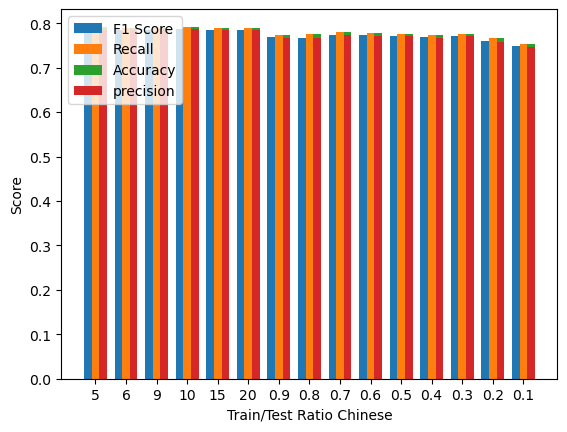

In [48]:
# Language: Chinese
# Compare 80/20, 70/30, 60/40 and 50/50 ratios

import matplotlib.pyplot as plt
import numpy as np

# Get the data for the graph
labels = [result[0] for result in results]
f1_scores = [result[1] for result in results]
recall_scores = [result[2] for result in results]
accuracy_scores = [result[3] for result in results]
precision_scores = [result[4] for result in results]

# Set the width of the bars and the x-axis offset
bar_width = 0.25
x_offset = np.arange(len(labels))

# Plot the data as a grouped bar graph
fig, ax = plt.subplots()
ax.bar(x_offset - bar_width, f1_scores, width=bar_width, label='F1 Score')
ax.bar(x_offset, recall_scores, width=bar_width, label='Recall')
ax.bar(x_offset + bar_width, accuracy_scores, width=bar_width, label='Accuracy')
ax.bar(x_offset + bar_width, precision_scores, width=bar_width, label='precision')

# Add labels and legend
ax.set_xlabel('Train/Test Ratio Chinese')
ax.set_ylabel('Score')
ax.set_xticks(x_offset)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()

In [59]:
# Chinese
# Train/test ratio
# Maximum Entropy

# Import additional required modules
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score
import numpy as np
import re
import jieba

df = pd.read_csv('ChnSentiCorp_htl_all_translated.csv')
df['review'] = df['review'].apply(str)
df['translated_review'] = df['translated_review'].apply(str)

# Define a function to keep only Chinese characters in a string
def keep_chinese(text):
    pattern = re.compile(r'[^\u4e00-\u9fff\s]')
    chinese_only = pattern.sub('', text)
    return chinese_only.strip()

# Tokenize the Chinese words and keep only the Chinese characters in each word
df['words-chinese'] = df['review'].apply(lambda x: [keep_chinese(word) for word in jieba.cut(x, cut_all=False) if keep_chinese(word) != ''])

# Calculate the mean of TF-IDF values for each tokenized sentence
vectorizer = TfidfVectorizer(use_idf=True)
X_tfidf = vectorizer.fit_transform(df['words-chinese'].apply(lambda x: ' '.join(x)))
df['tf-idf'] = np.mean(X_tfidf.toarray(), axis=1)

# Train a Word2Vec model and calculate the mean of word embeddings for each tokenized sentence
word2vec_model = Word2Vec(sentences=df['words-chinese'], vector_size=100, window=5, min_count=1, workers=4)

def mean_word2vec(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['word2vec'] = df['words-chinese'].apply(lambda x: mean_word2vec(x, word2vec_model))

# Combine the reshaped 'tf-idf' values and 'word2vec' values
X = np.hstack((tf_idf_reshaped, np.vstack(df['word2vec'].values)))
y = df['label'].values

# Test different train/test ratios
ratios = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
results = []
for ratio in ratios:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-ratio), random_state=42)

    # Train the Maximum Entropy classifier (Logistic Regression)
    maxent_model = LogisticRegression(random_state=42, max_iter=1000)
    maxent_model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = maxent_model.predict(X_test)

    # Calculate and report the F1 score, recall, and accuracy
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    results.append((ratio, f1, recall, accuracy, precision))

# Print the results
print('Train/Test Ratio\tF1 Score\tRecall\tAccuracy\tprecision')
for result in results:
    print('{}\t{:.4f}\t\t{:.4f}\t{:.4f}\t{:.4f}'.format(result[0], result[1], result[2], result[3], result[4]))

Train/Test Ratio	F1 Score	Recall	Accuracy	precision
0.9	0.7905		0.7954	0.7954	0.7906
0.8	0.8019		0.8069	0.8069	0.8022
0.7	0.8135		0.8176	0.8176	0.8132
0.6	0.8108		0.8159	0.8159	0.8113
0.5	0.8071		0.8120	0.8120	0.8070
0.4	0.8078		0.8129	0.8129	0.8080
0.3	0.8040		0.8098	0.8098	0.8049
0.2	0.8003		0.8061	0.8061	0.8006
0.1	0.8011		0.8066	0.8066	0.8011


In [60]:
# English
# Maixmum entropy

# Import additional required modules
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('ChnSentiCorp_htl_all_translated.csv')
df['review'] = df['review'].apply(str)
df['translated_review'] = df['translated_review'].apply(str)

# Define a function to keep only English characters in a string
def keep_english(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    english_only = pattern.sub('', text)
    return english_only.strip()

# Tokenize the English words and keep only the English characters in each word
df['words-english'] = df['translated_review'].apply(lambda x: [keep_english(word) for word in nltk.word_tokenize(x) if keep_english(word) != ''])

# Calculate the mean of TF-IDF values for each tokenized sentence
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['words-english'].apply(lambda x: ' '.join(x)))
df['tf-idf'] = np.mean(X_tfidf.toarray(), axis=1)

# Train a Word2Vec model and calculate the mean of word embeddings for each tokenized sentence
word2vec_model = Word2Vec(sentences=df['words-english'], vector_size=100, window=5, min_count=1, workers=4)

def mean_word2vec(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['word2vec'] = df['words-english'].apply(lambda x: mean_word2vec(x, word2vec_model))

# Combine the reshaped 'tf-idf' values and 'word2vec' values
X = np.hstack((df['tf-idf'].values.reshape(-1, 1), np.vstack(df['word2vec'].values)))
y = df['label'].values

# Initialize lists to store performance metrics for each ratio
f1_scores = []
recall_scores = []
accuracy_scores = []
precision_scores = []
# Iterate over the ratios
for ratio in ratios:
    # Split the data into training and testing sets using the current ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ratio, random_state=42)
    
    # Train the Maximum Entropy classifier (Logistic Regression)
    maxent_model = LogisticRegression(random_state=42, max_iter=1000)
    maxent_model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = maxent_model.predict(X_test)

    # Calculate and store the performance metrics for the current ratio
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    f1_scores.append(f1)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)

# Print the performance metrics for each ratio
print(f'Ratio\t\tF1 Score\tRecall\t\tAccuracy\tPrecision')
for i in range(len(ratios)):
    print(f'{ratios[i]:.1f}\t\t{f1_scores[i]:.4f}\t\t{recall_scores[i]:.4f}\t\t{accuracy_scores[i]:.4f}\t\t{precision_scores[i]:.4f}')

Ratio		F1 Score	Recall		Accuracy	Precision
0.9		0.7740		0.7807		0.7807		0.7732
0.8		0.7755		0.7835		0.7835		0.7759
0.7		0.7705		0.7784		0.7784		0.7707
0.6		0.7693		0.7760		0.7760		0.7684
0.5		0.7671		0.7736		0.7736		0.7659
0.4		0.7642		0.7715		0.7715		0.7634
0.3		0.7650		0.7717		0.7717		0.7638
0.2		0.7541		0.7619		0.7619		0.7535
0.1		0.7401		0.7490		0.7490		0.7402


In [56]:
# Chinese k-fold maximum entropy
from sklearn.linear_model import LogisticRegression

# Chinese k-fold k = [5, 6, 9, 10, 15, 20]
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
import numpy as np
import re
import jieba
import matplotlib.pyplot as plt

df = pd.read_csv('ChnSentiCorp_htl_all_translated.csv')
df['review'] = df['review'].apply(str)
df['translated_review'] = df['translated_review'].apply(str)

# Define a function to keep only Chinese characters in a string
def keep_chinese(text):
    pattern = re.compile(r'[^\u4e00-\u9fff\s]')
    chinese_only = pattern.sub('', text)
    return chinese_only.strip()

# Tokenize the Chinese words and keep only the Chinese characters in each word
df['words-chinese'] = df['review'].apply(lambda x: [keep_chinese(word) for word in jieba.cut(x, cut_all=False) if keep_chinese(word) != ''])

# Calculate the mean of TF-IDF values for each tokenized sentence
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['words-chinese'].apply(lambda x: ' '.join(x)))
df['tf-idf'] = np.mean(X_tfidf.toarray(), axis=1)

# Train a Word2Vec model and calculate the mean of word embeddings for each tokenized sentence
word2vec_model = Word2Vec(sentences=df['words-chinese'], vector_size=100, window=5, min_count=1, workers=4)

def mean_word2vec(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['word2vec'] = df['words-chinese'].apply(lambda x: mean_word2vec(x, word2vec_model))

# Combine the reshaped 'tf-idf' values and 'word2vec' values
X = np.hstack((tf_idf_reshaped, np.vstack(df['word2vec'].values)))
y = df['label'].values

# Test different k-values
k_values = [5, 6, 9, 10, 15, 20]
results = []
for k in k_values:
    # Initialize the KFold cross-validator with the current k-value
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    # Initialize lists to store performance metrics for each fold
    f1_scores = []
    recall_scores = []
    accuracy_scores = []
    precision_scores = []

    # Iterate over the k folds
    for train_index, test_index in kfold.split(X):
        # Split the data into training and testing sets for the current fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the Maximum Entropy classifier (Logistic Regression)
        maxent_model = LogisticRegression(random_state=42, max_iter=1000)
        maxent_model.fit(X_train, y_train)

        # Predict on the testing set
        y_pred = maxent_model.predict(X_test)

        # Calculate and store the performance metrics for the current fold
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))

    # Calculate and store the average performance metrics across all k folds for the current k-value
    average_f1 = np.mean(f1_scores)
    average_recall = np.mean(recall_scores)
    average_accuracy = np.mean(accuracy_scores)
    average_precision = np.mean(precision_scores)

    results.append((k, average_f1, average_recall, average_accuracy, average_precision))

    # Print the results for the current k-value
    print(f'k={k}, F1 Score: {average_f1:.4f}, Recall: {average_recall:.4f}, Accuracy: {average_accuracy:.4f}, Precision: {average_precision:.4f}')

k=5, F1 Score: 0.8196, Recall: 0.8237, Accuracy: 0.8237, Precision: 0.8196
k=6, F1 Score: 0.8196, Recall: 0.8238, Accuracy: 0.8238, Precision: 0.8197
k=9, F1 Score: 0.8201, Recall: 0.8244, Accuracy: 0.8244, Precision: 0.8204
k=10, F1 Score: 0.8204, Recall: 0.8246, Accuracy: 0.8246, Precision: 0.8206
k=15, F1 Score: 0.8199, Recall: 0.8240, Accuracy: 0.8240, Precision: 0.8203
k=20, F1 Score: 0.8198, Recall: 0.8238, Accuracy: 0.8238, Precision: 0.8205


In [58]:
# Language: English k-fold maximum entropy

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
import numpy as np
import re
import nltk
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('ChnSentiCorp_htl_all_translated.csv')
df['review'] = df['review'].apply(str)
df['translated_review'] = df['translated_review'].apply(str)

# Define a function to keep only English characters in a string
def keep_english(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    english_only = pattern.sub('', text)
    return english_only.strip()

# Tokenize the English words and keep only the English characters in each word
df['words-english'] = df['translated_review'].apply(lambda x: [keep_english(word) for word in nltk.word_tokenize(x) if keep_english(word) != ''])

# Calculate the mean of TF-IDF values for each tokenized sentence
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['words-english'].apply(lambda x: ' '.join(x)))
df['tf-idf'] = np.mean(X_tfidf.toarray(), axis=1)

# Train a Word2Vec model and calculate the mean of word embeddings for each tokenized sentence
word2vec_model = Word2Vec(sentences=df['words-english'], vector_size=100, window=5, min_count=1, workers=4)

def mean_word2vec(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['word2vec'] = df['words-english'].apply(lambda x: mean_word2vec(x, word2vec_model))

# Combine the reshaped 'tf-idf' values and 'word2vec' values
X = np.hstack((df['tf-idf'].values.reshape(-1, 1), np.vstack(df['word2vec'].values)))
y = df['label'].values

# Define the values of k to iterate over
k_values = [5, 6, 9, 10, 15, 20]

# Initialize an empty list to store the results for each value of k
results = []

# Iterate over the k values and perform k-fold cross-validation
for k in k_values:
    # Initialize the KFold cross-validator with the current value of k
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    # Initialize lists to store performance metrics for each fold
    f1_scores = []
    recall_scores = []
    accuracy_scores = []
    precision_scores = []

    # Iterate over the k folds
    for train_index, test_index in kfold.split(X):
        # Split the data into training and testing sets for the current fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the Maximum Entropy classifier (Logistic Regression)
        maxent_model = LogisticRegression(random_state=42, max_iter=1000)
        maxent_model.fit(X_train, y_train)

        # Predict on the testing set
        y_pred = maxent_model.predict(X_test)

        # Calculate and store the performance metrics for the current fold
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))

    # Calculate and store the average performance metrics for the current value of k
    average_f1 = np.mean(f1_scores)
    average_recall = np.mean(recall_scores)
    average_accuracy = np.mean(accuracy_scores)
    average_precision = np.mean(precision_scores)
    results.append([k, average_f1, average_recall, average_accuracy, average_precision])
    # Print the results for the current k-value
    print(f'k={k}, F1 Score: {average_f1:.4f}, Recall: {average_recall:.4f}, Accuracy: {average_accuracy:.4f}, Precision: {average_precision:.4f}')

k=5, F1 Score: 0.7753, Recall: 0.7837, Accuracy: 0.7837, Precision: 0.7761
k=6, F1 Score: 0.7740, Recall: 0.7820, Accuracy: 0.7820, Precision: 0.7743
k=9, F1 Score: 0.7756, Recall: 0.7841, Accuracy: 0.7841, Precision: 0.7766
k=10, F1 Score: 0.7763, Recall: 0.7845, Accuracy: 0.7845, Precision: 0.7771
k=15, F1 Score: 0.7758, Recall: 0.7841, Accuracy: 0.7841, Precision: 0.7771
k=20, F1 Score: 0.7763, Recall: 0.7843, Accuracy: 0.7843, Precision: 0.7779
